# ML-Based Global Poverty Risk Modeling

The goal of this project is to perform an exploratory data analysis and modeling in order to answer the following questions:

1. What percentage of the world population lives in extreme poverty? 
2.  Which characteristics are predictive for countries with large populations living in extreme poverty?
3.  Which characteristics are predictive for populations emerging from extreme poverty?


In [1]:
# Standard imports
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore')

# sklearn imports
import sklearn as sk
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler

# Special imports
import geopandas as gpd
import plotly.graph_objects as px

from lightgbm import LGBMClassifier

from imblearn.over_sampling import RandomOverSampler

import world_bank_data as wb # https://github.com/mwouts/world_bank_data


# Data Gathering: World Bank Database and Poverty

In order to answer the questions mentioned above, multiple datasets from the world bank are used. We obtain worldbank databases using the library world_bank_data. We request for a list of indicators all data sequentially and merge them into a dataframe.

The indicators can be obtained for each database downloading the metadata manually from world bank (as it was done here), or using the library with the function "get_indicators" which allows to specify topic and source.

To this end, we define two funtions. After we obtain the data we make a first attempt at analysing the poverty data.

## Function definitions

For the data extraction, we use function **get_series** from **world_bank_data** which takes as input an indicator code. We format the output into a dataframe. This is done in function **get_series_api**.

To get the entire database, we loop over the indicators which we have previously downloaded. For each indicator we call the previous function, and the resulting dataframe is merged to the previous one. This is done in function **get_database**. This function also returns a dictionary with the indicators for which the extraction failed.

In [2]:
def get_series_api(indicator):
    '''
    Get series from world data bank.
      
    Parameters
    ----------
    indicator : string
        world bank series indicator code.

    Returns
    -------
    df : dataframe
        dataframe with columns Country, Year, [Series Name].
    '''
    s = wb.get_series(indicator)
    df = s.reset_index()
    df.rename(columns={df.columns[3]: df.Series[0]}, inplace =True)
    df.drop(['Series'], axis=1, inplace=True)
    return df


def get_database(indicator_codes):
    '''
    Get data for indicator codes provided 
    
    Parameters
    ----------
    indicator_codes : dataframe
        dataframe which first column contain indicator codes

    Returns
    -------
    list
        list with two elements:
            - dataframe with data
            - dictionary with row number and indicator for which extraction failed
    '''
    data = pd.DataFrame()
    prob = dict()
    for j in range(0,len(indicator_codes)):
        try:
            df = get_series_api(indicator_codes.iloc[j,0])
            if data.empty:
                data = df
            else:
                data = pd.merge(data,df,how='outer')
        except:
            prob[j]=indicator_codes.iloc[j,0]  
            
    data = pd.merge(data, countries, left_on='Country', right_on='name')     
    data.drop(['name'], axis=1, inplace=True)
    return [data, prob]

## Database download

Using the previously defined functions and a list of indicators codes (easily obtained manually from https://databank.worldbank.org/home.aspx), we download the following datasets from from the world bank site:

- Education Data
- Gender Data
- Health Data
- World Development Indicators


In [3]:
GENDER_CODES = pd.read_csv('data/wb_api/indicators_gender.csv')
EDUCATION_CODES = pd.read_csv('data/wb_api/indicators_education.csv')
HEALTH_CODES = pd.read_csv('data/wb_api/indicators_health.csv')
WORLD_DEV_CODES = pd.read_csv('data/wb_api/indicators_worlddevelopment.csv')


start = time.time()
"""
#We coment this cell because we estracted the files once
"""

# gender = get_database(GENDER_CODES)
# education = get_database(EDUCATION_CODES)
# health = get_database(HEALTH_CODES)
# worlddev = get_database(WORLD_DEV_CODES)
# results:  1/574, 3/3818, 1/407, 0/1434 (fails/successes)

end = time.time()
# print(end - start)
# 2,5 hours

Lastly we saved the resulting lists (dataframe + dictionary with failed attempts) to a pickle, respectively the dataframes each to a csv file.

In [4]:
#Save results
"""
#We comment also this out because we downloaded the files once
"""

# with open('gender.pkl', 'wb') as f:
#     pickle.dump(gender, f)
# with open('education.pkl', 'wb') as f:
#     pickle.dump(education, f)
# with open('health.pkl', 'wb') as f:
#     pickle.dump(health, f)
# with open('worlddev.pkl', 'wb') as f:
#     pickle.dump(worlddev, f)
    
# gender[0].to_csv('wb_gender.csv', index=False)
# education[0].to_csv('wb_education.csv', index=False)
# health[0].to_csv('wb_health.csv', index=False)
# worlddev[0].to_csv('wb_worlddev.csv', index=False)

'\n#We comment also this out because we downloaded the files once\n'

## Ground Truth

The ground truth considered in our analysis is the poverty headcount defined by the world bank as the percentage of population living with less than a certain amount (\\$1.9, \\$3.2 or \\$5.5) per day.  

For the purpose of thise exercise, the headcount which is based on \\$1.9 is used.


In [5]:
# Path for the headcount data considering $1.9 as a threshold
HEAD_COUNT_DATA_19_PATH = 'data/CountryTable_1.9.csv'
# Path for the headcount data considering $3.2 as a threshold
HEAD_COUNT_DATA_32_PATH = 'data/CountryTable_3.2.csv'
# Path for the headcount data considering $5.5 as a threshold
HEAD_COUNT_DATA_55_PATH = 'data/CountryTable_5.5.csv' 

# Path for the different world bank datasets
WB_DATA_PATHS = ['data/wb_api/wb_education.csv', 
                 'data/wb_api/wb_gender.csv', 
                 'data/wb_api/wb_health.csv', 
                 'data/wb_api/wb_worlddev.csv']

def load_headcount_data(threshold):
    """Load the headcount data for each country
    
    Parameters
    ----------
    threshold : float
        Threshold that is considered to calculate the headcount for each country. Should be 1.9, 3.2 or 5.5.
    
    Returns
    -------
    data : pandas DataFrame
        A dataframe including the head count data for each country
    countries : pandas DataFrame
        A dataframe including all countries and information about them
    """
    if threshold == 1.9:
        data = pd.read_csv(HEAD_COUNT_DATA_19_PATH, na_values=-1)
    elif theshold == 3.2:
        data = pd.read_csv(HEAD_COUNT_DATA_32_PATH, na_values=-1)
    elif threshold == 5.5:
        data = pd.read_csv(HEAD_COUNT_DATA_55_PATH, na_values=-1)
    else:
        raise ValueError('threshold should be 1.9, 3.2 or 5.5')
    
    countries = wb.get_countries()
    countries = countries.reset_index()
    countries = countries.loc[:,['id','iso2Code','name','region','incomeLevel']]
    countries = countries.loc[countries['id'].isin(data.CountryCode.tolist()),:].reset_index(drop=True)
    
    return data, countries

countrypov_19, countries = load_headcount_data(1.9)

def load_raw_data(firstyear = 1990, lastyear = 2019, countries = countries.id):
    """Load the different world bank datasets within a defined period and merge them
    
    Parameters
    ----------
    firstyear : integer
        First year of the period for which the data will be returned
    lastyear : integer
        Last year of the period for which the data will be returned
    countries : pandas Series
        List of all countries ids
    
    
    Returns
    -------
    data_list : list of pandas DataFrames
        A list of the loaded datasets  
    data : pandas DataFrame
        A dataframe including all merged data for the selected period
    """
    data_list = []
    for path in WB_DATA_PATHS:
        df = pd.read_csv(path)
        df = df.loc[(df.Year>=firstyear)&(df.Year<=lastyear)&(df.id.isin(countries))]
        df = df.reset_index(drop=True)
        data_list.append(df)
    
    # Merge Datasets
    gender_cols = data_list[1].columns.difference(data_list[0].columns).to_list()+['id','Year']
    data = pd.merge(data_list[0], data_list[1][gender_cols], on=['id','Year'])
    health_cols = data_list[2].columns.difference(data.columns).to_list()+['id','Year']
    data = pd.merge(data, data_list[2][health_cols], on=['id','Year'])
    worlddev_cols = data_list[3].columns.difference(data.columns).to_list()+['id','Year']
    data = pd.merge(data, data_list[3][worlddev_cols], on=['id','Year'])
    
    return data_list, data


In [6]:
print(countrypov_19.RequestYear.unique())

[1981 1984 1987 1990 1993 1996 1999 2002 2005 2008 2010 2011 2012 2013
 2015]


The previously mentioned four are used considering data between 1990 and 2019. The shape of each of them is as follows:

- Education Data: (4920, 3818)
- Gender Data: (4920, 574)
- Health Data: (4920, 407)
- World Development Indicators: (4920, 1434)

The shape of the merged dataset is (4920, 5476)

The headcount data is available for the following years: 1981, 1984, 1987, 1990, 1993, 1996, 1999, 2002, 2005, 2008, 2010, 2011, 2012, 2013 and 2015.

# Exploratory Data Analysis

## Population Analysis

For the population data, since we are only interested on analyzing the population on a national level, we get rid of rural and city accounts of poverty in the dataset. Also, we notice that from the countries available for 2013, only Venezuela is not for 2015. We add the 2013 value to 2015 since this is a significant country in terms of population and poverty.

In [7]:
# select national statistics (not rural or city statistics)
countrypov_19 = countrypov_19.loc[countrypov_19.CoverageType.isin(['N','A']),:]

index = countrypov_19.loc[(countrypov_19.RequestYear == 2013),'CountryCode'].isin(countrypov_19.loc[(countrypov_19.RequestYear == 2015),'CountryCode'])

# print missing country codes in 2015
print(countrypov_19.loc[(countrypov_19.RequestYear == 2013) & ~index,'CountryCode'])

# assign 2013 value to 2015 values
temp = countrypov_19.loc[(countrypov_19.RequestYear == 2013) & (countrypov_19.CountryCode == 'VEN'),:]
temp.RequestYear = 2015
countrypov_19 = pd.concat([countrypov_19, temp], join="inner")
countrypov_19.loc[(countrypov_19.RequestYear == 2015), :].info()

2325    VEN
Name: CountryCode, dtype: object
<class 'pandas.core.frame.DataFrame'>
Int64Index: 163 entries, 2331 to 2325
Data columns (total 32 columns):
isInterpolated       163 non-null int64
useMicroData         163 non-null int64
CountryCode          163 non-null object
CountryName          163 non-null object
RegionCode           163 non-null object
CoverageType         163 non-null object
RequestYear          163 non-null int64
DataYear             138 non-null float64
DataType             163 non-null object
PPP                  163 non-null float64
PovertyLine          163 non-null float64
Mean                 163 non-null float64
HeadCount            163 non-null float64
PovGap               163 non-null float64
PovGapSqr            163 non-null float64
Watts                163 non-null float64
Gini                 135 non-null float64
Median               135 non-null float64
pr.mld               135 non-null float64
Polarization         5 non-null float64
ReqYearPopulation  

## Hand-picked examples

We now load some hand-picked indicators using **get_database** to illustrate their relationship to the poverty headcount:


In [8]:
indicators = pd.DataFrame(['SP.POP.TOTL','NE.EXP.GNFS.ZS', 'NE.IMP.GNFS.ZS',
                                 'GC.TAX.TOTL.GD.ZS', 'NY.GNP.PCAP.PP.CD', 'NY.GNP.PCAP.CD',
                                 'NY.GDP.PCAP.KD','SE.ADT.LITR.ZS', 'NV.IND.TOTL.ZS',
                                 'SI.POV.GINI','SH.DYN.MORT','SP.DYN.LE00.IN', 'AG.LND.TRAC.ZS',
                                 'VC.IHR.PSRC.P5','SP.DYN.CDRT.IN','SL.UEM.TOTL.ZS',
                                 'SP.POP.GROW','SP.MTR.1519.ZS','EN.POP.DNST',
                                 'NY.ADJ.DRES.GN.ZS', 'NY.GDP.TOTL.RT.ZS', 'SE.PRM.UNER.ZS'])

data_list = get_database(indicators)
print(data_list[1]) # if dictionary is empty: all indicators were succesfully loaded!
data = data_list[0]
data.rename(columns = {'Population, total':'population'},inplace=True)
data['Year'] = pd.to_numeric(data['Year'],errors='coerce')


{}


And then merge them with our poverty headcount data. We also add the field *population_poverty* where we calculate the total number of persons living under extreme poverty per country.

In [9]:
data_ext = pd.merge(countrypov_19, data, how='inner',
                    left_on=['CountryCode','RequestYear'],
                    right_on=['id','Year'])
data_ext.drop(['Country','Year'], axis= 1, inplace=True)

data_ext['population_poverty'] = data_ext['population']*data_ext['HeadCount']

## Aggregated view

We use the following function to explore the population living under extreme poverty around the world. It groups total population and poverty according to the provided feature. If the feature is numerical we have to provide also a grouping criteria.

In [10]:
def agg_view(data, feature, num = True, bins = 5, labels=['very low', 'low', 'middle', 'high', 'very high'], left = True,
            obs_year = 2015, span_missing = 3):
    '''
    Calculates table with extreme poverty statistics based on the featured provided

    Parameters
    ----------
    data : dataframe
        Dataframe with population and population in extreme poverty per country containing "feature".
    feature : string
        Feature/column name for which the statistics should be provided
    num : boolean, optional
        Whether the feature provided is numerical or not. The default is True.
    bins : integer, sequence of scalars, or IntervalIndex; optional
        The criteria to bin by. The default is 5.
    labels : list, optional
        Specifies the labels for the returned bins. The default is ['very low', 'low', 'middle', 'high', 'very high'].
    left : boolean, optional
        Whether the first interval should be left-inclusive or not. The default is True.
    obs_year: integer, optional
        Reference year in statistics
    span_missing = integer, optional
        span of years to be used before and after the reference year to fill missing data

    Returns
    -------
    aggdf : dataframe
        Contains the following figures for each group of the given feature: population, population in percentage of the world population,
        population under the poverty line, population under the poverty line in percentage of the country population as well as in percentage
        of the world population in poverty and of the general world population.

    '''
    df = data.copy()

    df = df.loc[(df.RequestYear >= (obs_year - span_missing)) & (df.RequestYear <= (obs_year + span_missing)),:]
    df = df.groupby('CountryCode').apply(lambda x: x.fillna(method='ffill'))
    df = df.groupby('CountryCode').apply(lambda x: x.fillna(method='bfill'))
    df = df.loc[df.RequestYear == obs_year,:]

    if num:
        df[feature]=pd.cut(df[feature],bins=bins, labels=labels, include_lowest = left)
    if sum(df[feature].isna())>0:
        df[feature] = df[feature].cat.add_categories('NaN').fillna('NaN')
    
    aggdf = pd.DataFrame()
    aggdf['no_countries'] = df.groupby(feature)['population'].count()
    aggdf['population'] = df.groupby(feature)['population'].sum()
    aggdf['population_%_world'] = aggdf['population']/aggdf['population'].sum()
    aggdf['population_poverty'] = df.groupby(feature)['population_poverty'].sum()
    aggdf['population_poverty_%_country'] =aggdf['population_poverty']/aggdf['population']
    aggdf['population_poverty_%_world_poverty'] = aggdf['population_poverty']/aggdf['population_poverty'].sum()
    aggdf['population_poverty_%_world'] = aggdf['population_poverty']/aggdf['population'].sum()
    
    return aggdf

## Results and examples

### Introduction

We  first take a look at the world population living under the $1.9 poverty line per available year

#### Plot the population that lives in extreme poverty per region



The regions are:

* EAP: East Asia and Pacific
* ECA: Europe and Central Asia
* LAC: Latin American and the Caribbean
* MNA: Middle East and North Africa
* SAS: South Asia
* SSA: Sub-Saharan Africa

In [11]:
region_names = ["East Asia and Pacific","Europe and Central Asia", "Latin American and the Caribbean", 
                "Middle East and North Africa", "Other High Income", "South Asia", "Sub-Saharan Africa"]
region_codes_to_names = {"EAP": "East Asia and Pacific",
"ECA": "Europe and Central Asia",
"LAC": "Latin American and the Caribbean",
"MNA": "Middle East and North Africa",
"OHI": "Other High Income",
"SAS": "South Asia",
"SSA": "Sub-Saharan Africa"}

In [12]:
def plot_world_map(dataset, attribute='HeadCount', year=2015, cmap="Blues", title=None):
    """Plot the distribution of a given attribute over the world
    
    Parameters
    ----------
    dataset : pandas Dataframe
        Dataframe containing data over multiple years for multiple countries
    attribute : string
        Name of the attribute that will be plotted
    year : integer
        Year of the data that will be displayed
    cmap: matplotlib color map object
        Color map of the desired plot
    title: string
        Text that will be displayed on top of the plot
    """
    countries_copy = countries.rename(columns={"name":"CountryName"})
    dataset = dataset[['CountryName', attribute, 'RequestYear', 'id', 'CountryCode']]
    if year:
        data_year = dataset[dataset.RequestYear == year]
    else:
        data_year = dataset
    geo_processed_data = pd.merge(dataset[dataset.RequestYear == year],
                 countries_copy[['CountryName', 'id']],
                 on='CountryName', 
                 how='left')
    sns.set_style("white")
    shapefile = os.path.expanduser('data/ne_10m_admin_0_countries_lakes/ne_10m_admin_0_countries_lakes.shp')
    gdf = gpd.read_file(shapefile)[['ADM0_A3', 'geometry']].to_crs('+proj=robin')
    
    merged = gdf.merge(geo_processed_data, left_on='ADM0_A3', right_on='CountryCode', how="left")
    ax = merged.plot(figsize = (18,10), column=attribute, cmap=cmap, legend=True, k=8, edgecolor='black', linewidth=0.1)
    ax.set_title(title, fontsize=16, pad=20)
    
    merged[merged.isna().any(axis=1)].plot(ax=ax, color='#d3d3d3', hatch='///////', linewidth=0.1, edgecolor='#bdbdbd')

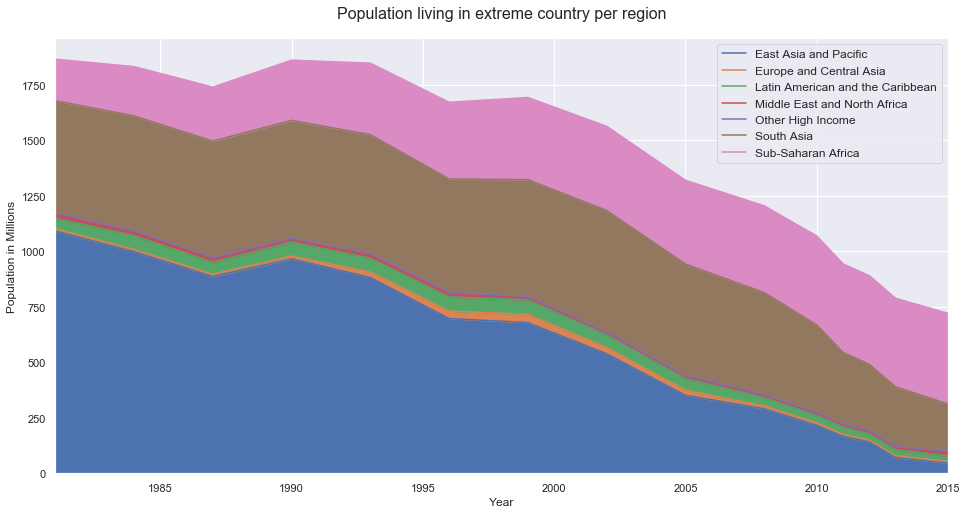

In [13]:
poverty_per_region = data_ext[["RegionCode", "HeadCount", "ReqYearPopulation", "RequestYear"]]
poverty_per_region["PopulationInExtremePoverty"] = poverty_per_region["ReqYearPopulation"] * poverty_per_region["HeadCount"]
poverty_per_region = poverty_per_region[["RegionCode", "PopulationInExtremePoverty", "RequestYear"]].groupby(["RegionCode",  "RequestYear"]).sum()
poverty_per_region.rename(index=region_codes_to_names, level='RegionCode', inplace=True)
poverty_per_region.sort_values(by='PopulationInExtremePoverty');
sns.set()
pal = sns.color_palette("Set1")
ax1 = poverty_per_region.unstack(level=0).plot(kind='area', stacked=True, figsize=(16,8))
ax1.legend(region_names, fontsize=12, loc = "upper right")
ax1.set_title("Population living in extreme country per region", fontsize=16, pad=20);
ax1.set_xlabel("Year");
ax1.set_ylabel("Population in Millions");

#### Plot the population that lives in extreme poverty in each country over the world

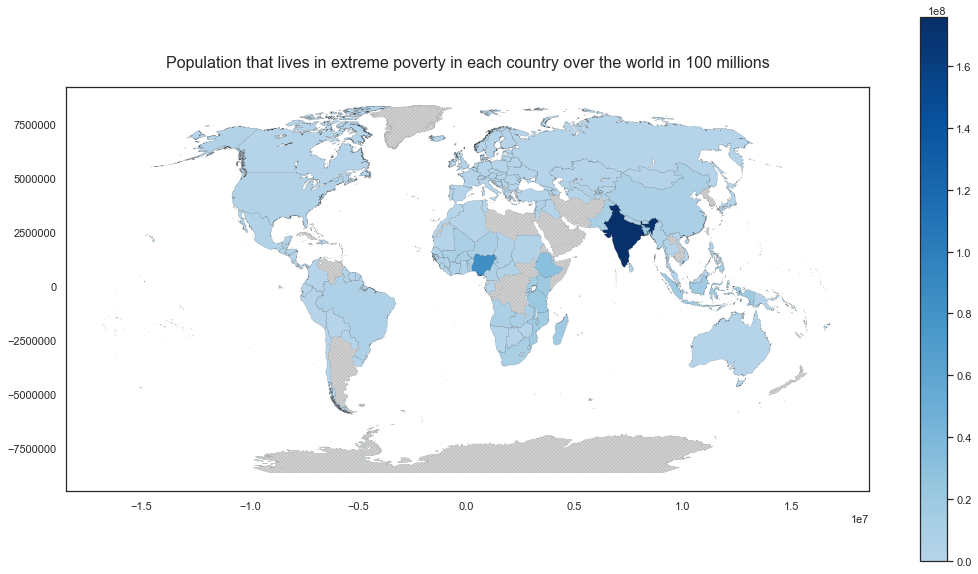

In [14]:
# Define a custom color map
cmap = mpl.cm.Blues(np.linspace(0,1,100))
cmap = mpl.colors.ListedColormap(cmap[30:,:-1])

plot_world_map(data_ext, attribute='population_poverty', year=2015, cmap=cmap, 
               title="Population that lives in extreme poverty in each country over the world in 100 millions")

#### Plot the percentage of population lives in extreme poverty in each country over the world

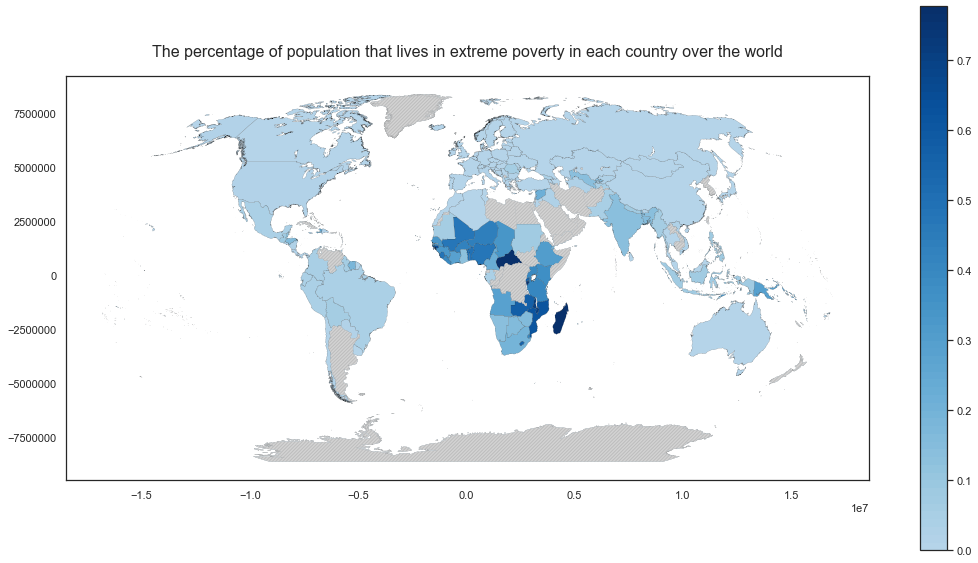

In [15]:
plot_world_map(data_ext, attribute='HeadCount', year=2015, cmap=cmap, 
               title="The percentage of population that lives in extreme poverty in each country over the world")

### HeadCount

First we can check how the poverty population is distributed according to the headcount level of each country.

In [16]:
edges = np.array([0,0.1,1,2,5,15,30,50,100])/100
# edges = data_ext.loc[data_ext.RequestYear == 2015, 'HeadCount'].quantile(q=np.array(range(0,101,10))/100) # other possibilty...
headcount_2015 = agg_view(data_ext, 'HeadCount', bins= edges, labels = None)
print(sum(headcount_2015.no_countries) == 163) #2015
headcount_2015

True


,no_countries,population,population_%_world,population_poverty,population_poverty_%_country,population_poverty_%_world_poverty,population_poverty_%_world
HeadCount,,,,,,,
"(-0.001, 0.001]",22,5.366913e+08,0.075754,5.910029e+04,0.000110,0.000083,0.000008
"(0.001, 0.01]",41,2.144326e+09,0.302673,1.296506e+07,0.006046,0.018120,0.001830
"(0.01, 0.02]",15,5.480171e+08,0.077353,7.372224e+06,0.013453,0.010303,0.001041
"(0.02, 0.05]",14,5.811101e+08,0.082024,1.896200e+07,0.032631,0.026501,0.002676
"(0.05, 0.15]",22,2.137312e+09,0.301682,2.359588e+08,0.110400,0.329774,0.033306
"(0.15, 0.3]",19,3.580748e+08,0.050542,6.853724e+07,0.191405,0.095787,0.009674
"(0.3, 0.5]",19,5.784295e+08,0.081646,2.331592e+08,0.403090,0.325861,0.032911
"(0.5, 1.0]",11,2.006794e+08,0.028326,1.385027e+08,0.690169,0.193570,0.019550


Interesting to notice here is that around half of the global population living under extreme poverty line lives in turn in countries where, on average, at least one third of the population live also under the 1.9 extreme poverty line. In 20% of the cases they are even the overwhelming majority where they live (there are 11 countries with around 70% of the population living under the extreme poverty). Most of the rest world poverty population (around 41%) lives in countries with significant headcounts, from 5% to 30%. Only 5% of the world poverty population lives in countries where they amount to 5% or less.

This is interesting with regard to how poverty concentrates today. If we look at the year 1981 (below), we can see that back then around 90% of the world population living under the threshold concentrated in only 35 countries with an average 74% of population living below the threshold. We can also see there are significantly more countries with very low levels of extreme poverty.

In [17]:
headcount_1981 = agg_view(data_ext, 'HeadCount', bins= edges, labels = None, obs_year =1981)
headcount_1981

,no_countries,population,population_%_world,population_poverty,population_poverty_%_country,population_poverty_%_world_poverty,population_poverty_%_world
HeadCount,,,,,,,
"(-0.001, 0.001]",21,3.018949e+08,0.069320,2.758512e+04,0.000091,0.000015,0.000006
"(0.001, 0.01]",23,6.876759e+08,0.157902,3.607274e+06,0.005246,0.001933,0.000828
"(0.01, 0.02]",6,7.329163e+07,0.016829,1.063914e+06,0.014516,0.000570,0.000244
"(0.02, 0.05]",12,1.658595e+08,0.038084,4.407567e+06,0.026574,0.002362,0.001012
"(0.05, 0.15]",21,2.681296e+08,0.061567,1.939513e+07,0.072335,0.010395,0.004453
"(0.15, 0.3]",21,4.728805e+08,0.108582,1.051434e+08,0.222347,0.056355,0.024143
"(0.3, 0.5]",12,1.482416e+08,0.034039,5.875876e+07,0.396372,0.031494,0.013492
"(0.5, 1.0]",35,2.237096e+09,0.513676,1.673331e+09,0.747993,0.896875,0.384226


In [18]:
headcount_period = headcount_1981[[ 'population_poverty_%_world_poverty']]
headcount_period = headcount_period.rename(columns = {'population_poverty_%_world_poverty': 'population_poverty_%_world_poverty_1981'})
headcount_period["population_poverty_%_world_poverty_2015"] = headcount_2015['population_poverty_%_world_poverty']

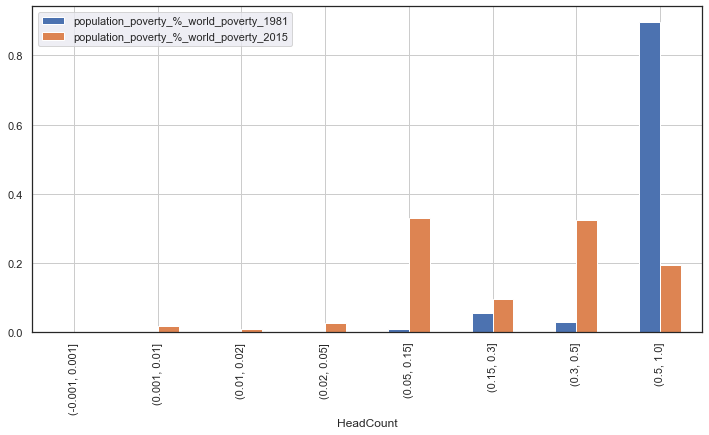

In [19]:
fig_pov = plt.figure(figsize=(12,6))
ax_pov = fig_pov.subplots()
sns.set()
headcount_period.plot(kind='bar', ax=ax_pov)

### Gini

Secondly, we take a look at poverty with respect to the Gini distribution. Apparently there is not a 1 to 1 relationship between inequality and extreme poverty. Although obviously there is a tendency to observe more poverty in countries with high inequality. In countries with very low inequality, we can also observe very low levels. Unluckily, for some 20 countries which account for 45% of the world poverty we do not have any gini measure.

In [20]:
edges = data_ext.loc[data_ext.RequestYear == 2015, 'Gini'].quantile(q=np.array(range(0,101,10))/100)
gini = agg_view(data_ext, 'Gini', bins=edges, labels=None)
print(sum(gini.no_countries) == 163) #2015
gini 

True


,no_countries,population,population_%_world,population_poverty,population_poverty_%_country,population_poverty_%_world_poverty,population_poverty_%_world
Gini,,,,,,,
"(0.253, 0.279]",14,1.672263e+08,0.023604,2.619546e+05,0.001566,0.000366,0.000037
"(0.279, 0.315]",13,1.084580e+08,0.015309,1.671000e+06,0.015407,0.002335,0.000236
"(0.315, 0.329]",14,5.123064e+08,0.072312,3.878479e+06,0.007571,0.005421,0.000547
"(0.329, 0.353]",14,2.160316e+08,0.030493,2.955011e+07,0.136786,0.041299,0.004171
"(0.353, 0.367]",15,4.218028e+08,0.059538,2.139310e+07,0.050718,0.029899,0.003020
"(0.367, 0.387]",13,2.978045e+08,0.042035,4.024621e+07,0.135143,0.056248,0.005681
"(0.387, 0.418]",17,6.408770e+08,0.090460,2.656472e+07,0.041451,0.037127,0.003750
"(0.418, 0.456]",16,5.993469e+08,0.084598,1.855097e+08,0.309520,0.259267,0.026185
"(0.456, 0.487]",13,1.543533e+08,0.021787,2.417943e+07,0.156650,0.033793,0.003413


## Missing Data

According to the World Bank, most of the data are missing due to conflict, lack of statistical resources, etc. This allow us to conclude that the data is not missing at random.

https://datahelpdesk.worldbank.org/knowledgebase/articles/191133-why-are-some-data-not-available

In [21]:
headcount_data, countries = load_headcount_data(1.9)
raw_data_list, raw_data = load_raw_data()
print(round(raw_data.isna().sum().sum()/(raw_data.shape[0]*raw_data.shape[1])*100, 2), "%")

74.86 %


### Plot heatmap of 100 random attributes

Since it is impossible to visualize all missing values, we plot the heatmap of the missing data of a randomly selected 100 attribute.

[]

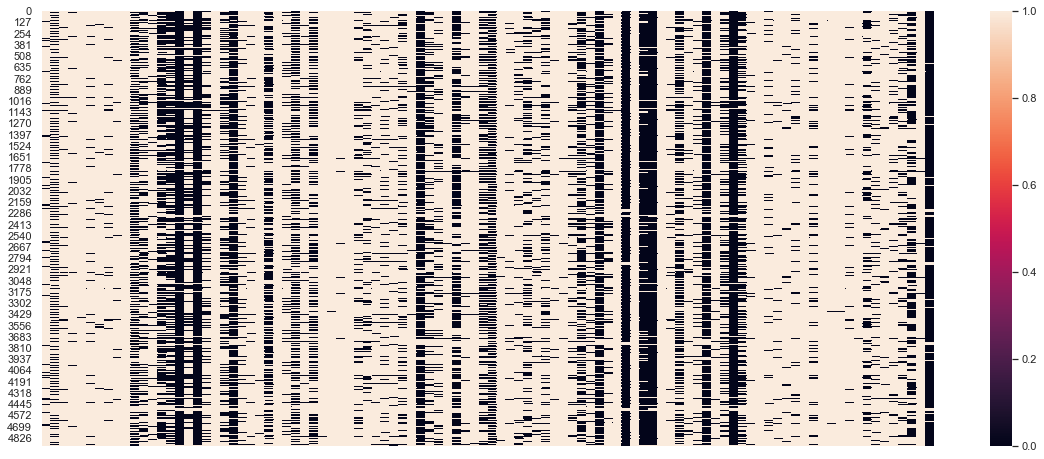

In [22]:
_, ax_hm = plt.subplots(figsize=(20,8))
sns.heatmap(raw_data.iloc[:, list(np.random.randint(0, 5200, size=(1, 100))[0])].isna(), ax=ax_hm)
ax_hm.set_xticks([])

# Data Preprocessing

We first read the country poverty data into variable **countrypov_19** and create a further variable countries containing the country information for the countries availiable in the poverty dataset. This is necessary to delimit the number of observation we need to work with and to efficiently merge later poverty data with the world bank databases.

In [23]:
countrypov_19, countries = load_headcount_data(1.9)

Next we define the function **load_and_prep** that performs some preprocessing for the desired reference year(s). Basically, the function performs imputation using the adjacent years per country as for the selected span and, afterwards, filters out all features that still contain more than a certain amount of missing values.

In [24]:
def load_and_prep(file, refyear = True, year = 2015, firstyear = 2008, lastyear = 2019, 
                    countries = countries.id, threshold = 0.2):
    '''
    
    Parameters
    ----------
    file : string
        File location of world bank database.
    refyear : boolean, optional
        Whether only the reference of interest should be selected or not. The default is True.
    year : integer, optional
        Reference year of interest. The default is 2015.
    firstyear : integer, optional
        Begin year for the selection span. The default is 2008.
    lastyear : integer, optional
        End year for the selection span. The default is 2019.
    countries : series or list, optional
        Countries to consider. The default is countries.id.
    threshold : float, optional
        Threshold for the amount of missing values. The default is 0.2.

    Returns
    -------
    df : dataframe
        Data after preprocessing steps.

    '''
    df = pd.read_csv(file)
    df = df.loc[(df.Year>=firstyear)&(df.Year<=lastyear)&(df.id.isin(countries))]
    df = df.groupby('id').apply(lambda x: x.fillna(method='ffill'))
    df = df.groupby('id').apply(lambda x: x.fillna(method='bfill'))
    if refyear:
        df = df.loc[(df.Year == year), :]
    index = ((df.isna().sum()/df.shape[0])<=threshold).to_list()
    df = df.loc[:,index]
    df = df.reset_index(drop=True)
    return df

Using this function we load and preprocess the education, gender, health and world development databases. Afterwards we merge them, taking care of duplicated features.

In [25]:
education = load_and_prep('data/wb_api/wb_education.csv')
gender = load_and_prep('data/wb_api/wb_gender.csv')
health = load_and_prep('data/wb_api/wb_health.csv')
worlddev = load_and_prep('data/wb_api/wb_worlddev.csv')


gender_cols = gender.columns.difference(education.columns).to_list()+['id','Year']
data = pd.merge(education, gender[gender_cols], on=['id','Year'])

health_cols = health.columns.difference(data.columns).to_list()+['id','Year']
data = pd.merge(data, health[health_cols], on=['id','Year'])

worlddev_cols = worlddev.columns.difference(data.columns).to_list()+['id','Year']
data = pd.merge(data, worlddev[worlddev_cols], on=['id','Year'])

In [26]:
# Merge with headcount poverty data (only 2015 data)
data_ext = pd.merge(countrypov_19, data, how='inner',
                    left_on=['CountryCode','RequestYear'],
                    right_on=['id','Year'])

edges = np.array([0,0.1,1,2,5,15,30,50,100])/100
data_ext['HeadCount_gr'] = pd.cut(data_ext['HeadCount'], bins=edges, include_lowest=True)
data_ext = data_ext.groupby('HeadCount_gr').apply(lambda x: x.fillna(x.mean()))
data_ext.drop('HeadCount_gr', axis=1, inplace=True)
index = ((data_ext.isna().sum()/data_ext.shape[0])==0).to_list()
data_ext = data_ext.loc[:,index]
data_ext.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 169 entries, 0 to 168
Columns: 1921 entries, isInterpolated to Wage and salaried workers, total (% of total employment) (modeled ILO estimate)
dtypes: float64(1908), int64(4), object(9)
memory usage: 2.5+ MB


## Correlation and categorical variables

To handle correlation, we begin by excluding variables directly related to the headcount measure at $1.90 a day and variables without predictive power like *CountryName*

In [27]:
cols_exc = ['HeadCount','PovGap','PovGapSqr','Watts',
       'Poverty gap at $1.90 a day (2011 PPP) (%)',
       'Poverty gap at $3.20 a day (2011 PPP) (%)',
       'Poverty gap at $5.50 a day (2011 PPP) (%)',
       'Poverty headcount ratio at $1.90 a day (2011 PPP) (% of population)',
       'Poverty headcount ratio at $3.20 a day (2011 PPP) (% of population)',
       'Poverty headcount ratio at $5.50 a day (2011 PPP) (% of population)',
       'RequestYear', 'Year', 'isInterpolated', 'useMicroData',
       'Country', 'CountryCode', 'CountryName', 'CoverageType', 'DataType',
        'RegionCode', 'SvyInfoID', 'id'] 

X = data_ext.drop(cols_exc, axis=1).select_dtypes('float64')

For the rest, we simply define a function that provides a list with all features with a pairwise correlation higher than a given threshold with respect to a previous feature (index-wise) in the dataframe which is not already in the list. The correlation "pruning" is performed in this case at 0.95 with *pearson* correlation.

In [28]:
def correlation_handling(data, threshold): 
    '''
    Parameters
    ----------
    data : dataframe
        Data for which highly correlated features should be excluded.
    threshold : float
        A value from 0 to 1 for the maximum correlation allowed.

    Returns
    -------
    Series
        Column names that are above the correlation threshold.

    '''
    corr_matrix = abs(data.corr())
    index_matrix = pd.DataFrame(np.where(corr_matrix>threshold)).transpose()
    col_corr = list() # Set of all the indexes of columns to delete
    for k in range(index_matrix.shape[0]):
        if index_matrix.iloc[k,0]!=index_matrix.iloc[k,1] and np.isin(index_matrix.iloc[k,:],col_corr).any() == False:
            col_corr.append(index_matrix.iloc[k,1])  
            
    # for checking purposes:        
    # index_matrix_names = pd.DataFrame({'feature1':pd.Series(X.columns)[index_matrix.iloc[:,0]].reset_index(drop=True),
    #                                'feature2':pd.Series(X.columns)[index_matrix.iloc[:,1]].reset_index(drop=True)})
    return pd.Series(data.columns)[col_corr]

# redefine X without columns
corr_cols =  correlation_handling(X,0.95)
to_exclude = corr_cols.append(pd.Series(cols_exc))


We exclude the list of correlated columns and take care of the only non float variable left, *region*, which we convert into dummy variables.

In [29]:
# Define X, y; exclude variables related to poverty line
y = data_ext['HeadCount']
X = data_ext[data_ext.columns.difference(to_exclude)]
X = pd.get_dummies(X)
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 169 entries, 0 to 168
Columns: 787 entries, Access to clean fuels and technologies for cooking (% of population) to region_Sub-Saharan Africa 
dtypes: float64(780), uint8(7)
memory usage: 1.0 MB


#### Plot heatmap of the correlation matrix of X

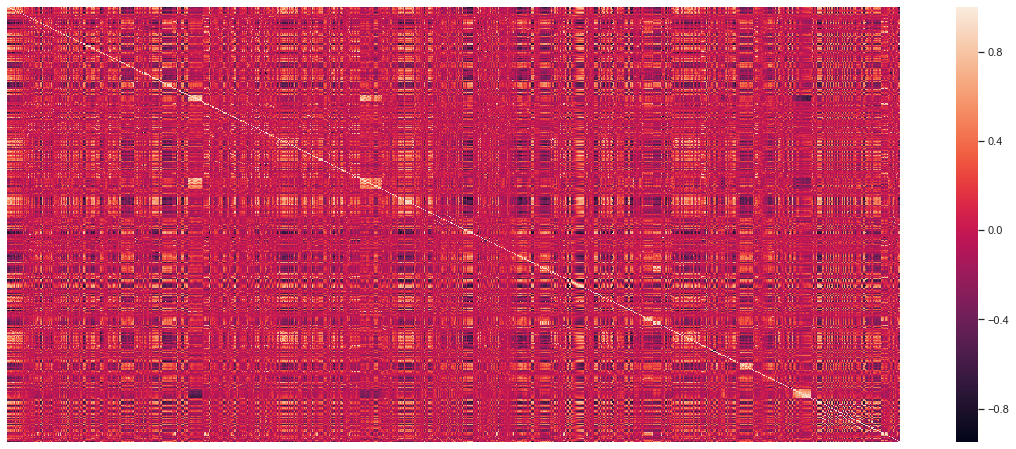

In [30]:
_, ax_corr = plt.subplots(figsize=(20,8))
sns.heatmap(X.corr(), ax=ax_corr)
ax_corr.set_yticks([]);
ax_corr.set_xticks([]);

# Feature Selection: Predictive characteristics of countries with larges populations living in extreme poverty 

In [31]:
K=30 #number of features we want to select

In [32]:
# Method 1: RandomForest

from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators = 1000, n_jobs=-1)
model.fit(X,y)

features_rank = pd.DataFrame({'importance': model.feature_importances_,
                              'columnind':range(0,len(model.feature_importances_))})

features_rank = features_rank.sort_values(by='importance', ascending =False)


X_rf = X.iloc[:,features_rank.columnind[:K]]


In [33]:
# Method 2: Univariate feature selection with f_classif
model2 = SelectKBest(score_func=f_classif, k=K).fit(X,y)
features_rank = pd.DataFrame({'importance': model2.scores_,
                              'columnind':range(0,len(model2.scores_))})

features_rank = features_rank.sort_values(by='importance', ascending =False)
X_f = X.iloc[:,features_rank.columnind[:K]]

In [34]:
print("====================== RANDOM FOREST ======================")
print(X_rf.columns)
print("\n====================== F-Classif ======================")
print(X_f.columns)

====================== RANDOM FOREST ======================
Index(['Median', 'Specialist surgical workforce (per 100,000 population)',
       'Human Capital Index (HCI) (scale 0-1)', 'Mean',
       'Adjusted net enrolment rate, upper secondary, both sexes (%)',
       'Probability of Survival to Age 5, Female',
       'Access to electricity (% of population)',
       'Survival Rate from Age 15-60, Female',
       'Adjusted net enrolment rate, lower secondary, both sexes (%)',
       'Adjusted net enrolment rate, one year before the official primary entry age, both sexes (%)',
       'Domestic private health expenditure per capita (current US$)',
       'Pump price for gasoline (US$ per liter)',
       'Agriculture, forestry, and fishing, value added per worker (constant 2010 US$)',
       'People using at least basic drinking water services (% of population)',
       'Risk of impoverishing expenditure for surgical care (% of people at risk)',
       'Mortality rate attributed to unsafe

The results are quite different. We will evaluate now on a test set the two different pre-selection methods and no pre-selection with a random forest.

## Simple Prediction with random forest

In [35]:
data_pred = pd.concat([X,data_ext['HeadCount']],axis=1)

### No feature selection

In [36]:
y = data_pred['HeadCount']
edges = np.array([0,0.1,1,2,5,15,30,50,100])/100
y_cuts = pd.cut(y, bins=edges, include_lowest=True)
X = data_pred.drop('HeadCount', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    stratify=y_cuts,
                                                    shuffle=True,
                                                    random_state=1502)


model = RandomForestRegressor(n_estimators = 1000, n_jobs=-1)
model.fit(X_train,y_train)

y_hat = model.predict(X_test)

sk.metrics.explained_variance_score(y_hat,y_test)

0.9402355087593679

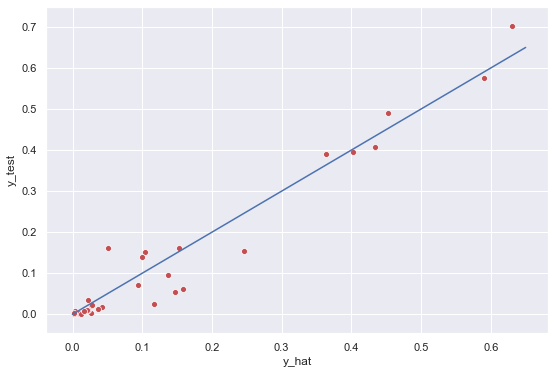

In [37]:
fig_rf_no = plt.figure(figsize=(9,6))
sns.set()
ax_rf_1 = fig_rf_no.subplots()
sns.scatterplot(x=y_hat, y=y_test, color='r', ax = ax_rf_1)
sns.lineplot(x=np.linspace(0,0.65,10), y=np.linspace(0,0.65,10), ax = ax_rf_1)
ax_rf_1.set_xlabel('y_hat');
ax_rf_1.set_ylabel('y_test');


In [38]:
features_rank = pd.DataFrame({'importance': model.feature_importances_,
                              'features':X.columns})
features_rank = features_rank.sort_values(by='importance', ascending =False)
print(type(features_rank))
print(features_rank.iloc[:K,])

<class 'pandas.core.frame.DataFrame'>
     importance                                           features
372    0.754893                                             Median
269    0.046758              Human Capital Index (HCI) (scale 0-1)
371    0.046580                                               Mean
10     0.019014  Adjusted net enrolment rate, upper secondary, ...
634    0.018413  Specialist surgical workforce (per 100,000 pop...
6      0.010408  Adjusted net enrolment rate, lower secondary, ...
533    0.005702           Probability of Survival to Age 5, Female
42     0.003294  Agriculture, forestry, and fishing, value adde...
462    0.003107  People using at least basic drinking water ser...
640    0.002976               Survival Rate from Age 15-60, Female
1      0.002646            Access to electricity (% of population)
67     0.002387  Cause of death, by communicable diseases and m...
2      0.001874  Access to electricity, urban (% of urban popul...
135    0.001867  Domesti

### Feature selection with random forest

In [39]:
y = data_pred['HeadCount']
edges = np.array([0,0.1,1,2,5,15,30,50,100])/100
y_cuts = pd.cut(y, bins=edges, include_lowest=True)
X = data_pred[X_rf.columns]

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    stratify=y_cuts,
                                                    shuffle=True,
                                                    random_state=1502)


model = RandomForestRegressor(n_estimators = 1000, n_jobs=-1)
model.fit(X_train,y_train)

y_hat = model.predict(X_test)

sk.metrics.explained_variance_score(y_hat,y_test)

0.9533097045139916

### Feature selection with f function

In [40]:
y = data_pred['HeadCount']
edges = np.array([0,0.1,1,2,5,15,30,50,100])/100
y_cuts = pd.cut(y, bins=edges, include_lowest=True)
X = data_pred[X_f.columns]

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    stratify=y_cuts,
                                                    shuffle=True,
                                                    random_state=1502)


model = RandomForestRegressor(n_estimators = 1000, n_jobs=-1)
model.fit(X_train,y_train)

y_hat = model.predict(X_test)

sk.metrics.explained_variance_score(y_hat,y_test)

0.7362177574931149

## Hyperparameter tuning with randomized search

Here we perform a hyperparameter tuning with randomized search for the random forest model. Then we fit the model with the best parameters and we predict for the test set. Predicted values are also plotted vs the expected ones.

In [41]:
y = data_pred['HeadCount']
edges = np.array([0,0.1,1,2,5,15,30,50,100])/100
y_cuts = pd.cut(y, bins=edges, include_lowest=True)
X = data_pred[X_rf.columns]

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    stratify=y_cuts,
                                                    shuffle=True,
                                                    random_state=1502)


num_vars = X.select_dtypes('float64').columns
scaler = ColumnTransformer([('scale', StandardScaler(), num_vars)])
rf = RandomForestRegressor(criterion = 'mse', random_state=1, n_jobs=-1)

pipe = Pipeline(steps=[('scaler', scaler), ('rf', rf)])

rf_grid = {'rf__bootstrap': [True, False],
           'rf__max_features': ['auto', 'sqrt'],
           'rf__max_depth': [2,4,8,10,15,20,30,50,75, None],
           'rf__n_estimators': [10,20,30,50,100,200,500,1000,2000,5000]}

grid_rf = RandomizedSearchCV(pipe, rf_grid, cv=10, n_jobs = -1)

In [42]:
grid_rf.fit(X_train, y_train)


y_hat = grid_rf.predict(X_test)

sk.metrics.mean_squared_error(y_hat,y_test)
print(sk.metrics.explained_variance_score(y_hat,y_test))

0.9543051130956668


Text(0, 0.5, 'y_test')

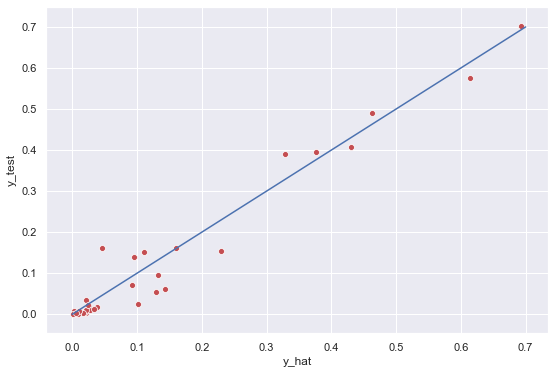

In [43]:
fig_rf_ht = plt.figure(figsize=(9,6))
sns.set()
ax_rf_2 = fig_rf_ht.subplots()
sns.scatterplot(x=y_hat, y=y_test, color='r', ax = ax_rf_2)
sns.lineplot(x=np.linspace(0,0.7,10), y=np.linspace(0,0.7,10), ax = ax_rf_2)
ax_rf_2.set_xlabel('y_hat')
ax_rf_2.set_ylabel('y_test')

In [44]:
features_rank = pd.DataFrame({'importance': grid_rf.best_estimator_.named_steps["rf"].feature_importances_,
                              'features': X.select_dtypes('float64').columns})

features_rank = features_rank.sort_values(by='importance', ascending =False)
features_rank

,importance,features
0,0.763632,Median
3,0.060646,Mean
2,0.048724,Human Capital Index (HCI) (scale 0-1)
1,0.027124,"Specialist surgical workforce (per 100,000 pop..."
4,0.019820,"Adjusted net enrolment rate, upper secondary, ..."
13,0.008653,People using at least basic drinking water ser...
8,0.008520,"Adjusted net enrolment rate, lower secondary, ..."
14,0.006654,Risk of impoverishing expenditure for surgical...
5,0.006459,"Probability of Survival to Age 5, Female"
19,0.005276,"Cause of death, by communicable diseases and m..."


### Only low to lower-middle income countries

Lastly, since median household income is very dominant, we take a look at what happened when we focus on countries with similar income levels.

In [45]:
low_income = countries.loc[countries.incomeLevel.isin(['Low income','Lower middle income']), 'id']
X = data_ext.loc[data_ext.CountryCode.isin(low_income),]
corr_cols =  correlation_handling(X,0.95)
to_exclude = corr_cols.append(pd.Series(cols_exc))
X = X[X.columns.difference(to_exclude)]
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77 entries, 2 to 168
Columns: 778 entries, Access to clean fuels and technologies for cooking (% of population) to Wittgenstein Projection: Population in thousands by highest level of educational attainment. Primary. Total
dtypes: float64(778)
memory usage: 468.6 KB


In [46]:
y = data_ext.loc[data_ext.id.isin(low_income),'HeadCount']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    #stratify=y_cuts,
                                                    shuffle=True,
                                                    random_state=1502)

model = RandomForestRegressor(n_estimators = 1000, n_jobs=-1)
model.fit(X_train,y_train)

y_hat = model.predict(X_test)

sk.metrics.mean_squared_error(y_hat,y_test)
print(sk.metrics.explained_variance_score(y_hat,y_test))

0.944463487311087


Text(0, 0.5, 'y_test')

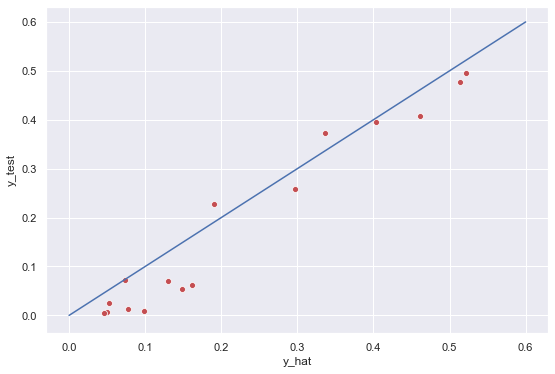

In [47]:
fig_rf_lm = plt.figure(figsize=(9,6))
sns.set()
ax_rf_3 = fig_rf_lm.subplots()
sns.scatterplot(x=y_hat, y=y_test, color='r', ax = ax_rf_3)
sns.lineplot(x=np.linspace(0,0.6,10), y=np.linspace(0,0.6,10), ax = ax_rf_3)
ax_rf_3.set_xlabel('y_hat')
ax_rf_3.set_ylabel('y_test')

### Only upper-middle to high income countries

In [48]:
high_income = countries.loc[countries.incomeLevel.isin(['Upper middle income','High income']), 'id']
X = data_ext.loc[data_ext.CountryCode.isin(high_income),]
corr_cols =  correlation_handling(X,0.95)
to_exclude = corr_cols.append(pd.Series(cols_exc))
X = X[X.columns.difference(to_exclude)]
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92 entries, 0 to 161
Columns: 803 entries, Access to electricity (% of population) to Wittgenstein Projection: Population in thousands by highest level of educational attainment. Primary. Total
dtypes: float64(803)
memory usage: 577.9 KB


In [49]:
y = data_ext.loc[data_ext.id.isin(high_income),['HeadCount','CountryName']]

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    #stratify=y_cuts,
                                                    shuffle=True,
                                                    random_state=1502)

names_train = y_train.CountryName
names_test = y_test.CountryName

y_train = y_train.HeadCount
y_test = y_test.HeadCount

model = RandomForestRegressor(n_estimators = 1000, n_jobs=-1)
model.fit(X_train,y_train)

y_hat = model.predict(X_test)

sk.metrics.mean_squared_error(y_hat,y_test)
print(sk.metrics.explained_variance_score(y_hat,y_test))

0.05719820776680251


Text(0, 0.5, 'y_test')

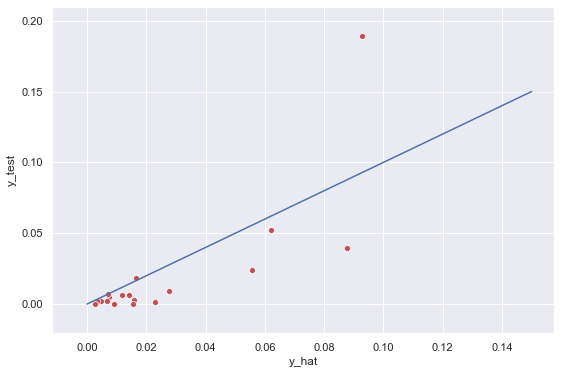

In [50]:
fig_rf_up = plt.figure(figsize=(9,6))
sns.set()
ax_rf_4 = fig_rf_up.subplots()
sns.scatterplot(x=y_hat, y=y_test, color='r', ax = ax_rf_4)
sns.lineplot(x=np.linspace(0,0.15,10), y=np.linspace(0,0.15,10), ax = ax_rf_4)
ax_rf_4.set_xlabel('y_hat')
ax_rf_4.set_ylabel('y_test')

Apparently we have a bad outlier in the test set. Let us identify it.

In [51]:
names_test[y_test>0.15]

136    South Africa
Name: CountryName, dtype: object

In [52]:
y_hat = y_hat[y_test<0.15]
y_test = y_test[y_test<0.15]
print(sk.metrics.explained_variance_score(y_hat,y_test))

0.7062203326511398


Still not great. It seems that in higher income countries, differences are more subtle and difficult to predict, but these again are not affected by extreme poverty in the same measure. If wanted to predict better these subtleties we would have to deal with outliers first.

# Feature Selection: Predictive characteristics of countries emmerging from extreme poverty

In order to define the features that characterizes countries emmerging from extreme poverty we investigate the evolution of the extreme poverty headcount between 1990 and 2015.

We start by loading and preprocessing the data. In addition we split the data (similar to what was done previoulsy) into multiple bins. We do this for the data from 1990 and 2015.

In [53]:
#Drop Columns
drop_columns = ['HeadCount','PovGap','PovGapSqr','Watts',
       'Poverty gap at $1.90 a day (2011 PPP) (%)',
       'Poverty gap at $3.20 a day (2011 PPP) (%)',
       'Poverty gap at $5.50 a day (2011 PPP) (%)',
       'Poverty headcount ratio at $1.90 a day (2011 PPP) (% of population)',
       'Poverty headcount ratio at $3.20 a day (2011 PPP) (% of population)',
       'Poverty headcount ratio at $5.50 a day (2011 PPP) (% of population)',
       'RequestYear', 'Year', 'isInterpolated', 'useMicroData',
       'Country', 'CountryCode', 'CountryName', 'CoverageType', 'DataType',
        'RegionCode', 'SvyInfoID', 'id']

def load_and_preprocess_data(year, firstyear, lastyear):
    """Load and preprocess the data and create bins
    
    Parameters
    ----------
    year : integer, optional
        Reference year of interest. The default is 2015.
    firstyear : integer, optional
        Begin year for the selection span. The default is 2008.
    lastyear : integer, optional
        End year for the selection span. The default is 2019.
    
    Returns
    -------
    df_bins : pandas DataFrame
        A dataframe including the preprocessed data
    """
    df = pd.DataFrame()
    for file in WB_DATA_PATHS:
        temp_df = load_and_prep(file, year=year, firstyear=firstyear, lastyear=lastyear)
        if df.empty:
            df = temp_df.copy()
        else:
            #Get the list of columns not present before
            column_list = temp_df.columns.difference(df.columns).to_list()+['id','Year']
            df = pd.merge(df, temp_df[column_list], on=['id','Year'])
    
    data_ext = pd.merge(countrypov_19, df,
                             how='inner',left_on=['CountryCode','RequestYear'],right_on=['id','Year'])
    
    data_ext['HeadCount_gr'] = pd.cut(data_ext['HeadCount'], bins=edges, include_lowest=True)
    df_bins = data_ext.groupby('HeadCount_gr').apply(lambda x: x.fillna(x.mean()))
    df_bins.drop('HeadCount_gr', axis=1, inplace=True)
    index = ((df_bins.isna().sum()/df_bins.shape[0])==0).to_list()
    df_bins = df_bins.loc[:,index]
    
    return df_bins

In [54]:
data_ext_2015 = load_and_preprocess_data(year = 2015, firstyear = 2008, lastyear = 2019)
data_ext_1990 = load_and_preprocess_data(year = 1990, firstyear = 1990, lastyear = 2000)

We classify countries into 5 categories based on the change of the extreme poverty headcount between 1990 and 2015. A country is defined as poor if more than 10% of its population is living in extreme povery.

The categories are:

* **Rich Countries (R)**: Countries that have a vlaue of extreme poverty headcount below 10% in 1990 and in 2015


* **Emmerging Countries 1 (E_R1)**: Countries that have a value of extreme poverty headcount above 10% in 1990 and below 10% in 2015 with a decrease in this value of 50% or more (head count in 2015 is half or less than half of what it was in 1990)


* **Emmerging Countries 2 (E_R2)**: Countries that have a value of extreme poverty headcount above 10% in 1990 and still above 10% in 2015 with a decrease in this value of more than 50% (head count is lower in 2015 but still above 10%)


* **Non-emmerging countries (NE)**: Countries where the head count in 1990 was more than 10% and still more than 10% in 2015 with a reduction of less than 50%


* **Countries going into extreme poverty (B)**: Countries with less than 10% head count in 1990 and more than 10% in 2015

In [55]:
def label_class_limit(row):
    """Label instances as R, E_R1, E_R2, NE and B based on poverty head count values
    
    Parameters
    ----------
    row : pandas dataframe row, optional
        row to label
    """
    if row['First_Period_Poverty'] == False and row['10%_Second_Period'] == True:
        return 'R'
    if row['First_Period_Poverty'] == True and row['50%_First_Period']== True and row['10%_Second_Period'] == True:
        return 'E_R1'
    if row['First_Period_Poverty'] == True and row['50%_First_Period'] == True and row['10%_Second_Period'] == False:
        return 'E_R2'
    if row['First_Period_Poverty'] == True and row['50%_First_Period'] == False:
        return 'NE'
    if row['First_Period_Poverty'] == False and row['10%_Second_Period'] == False:
        return 'B'

In [56]:
def get_class_range(first_period, second_period, suffix_1, suffix_2):
    """Construct a dataframe with countries labeled according to their poverty class
    
    Parameters
    ----------
    first_period : pandas Dataframe
        Data of the first period.
    second_period : pandas Dataframe
        Data of the second period.
    suffix_1 : string
        Suffix related to the first period. 
    suffix_2 : string
        Suffix related to the first period.
    
    Returns
    -------
    data_ext_hc : pandas DataFrame
        dataframe representing all countries labelled based on their poverty class
    """
    data_ext_1990_hc = first_period[['HeadCount', 'id']]
    data_ext_2015_hc = second_period[['HeadCount', 'id']]
    
    data_ext_hc = pd.merge(data_ext_1990_hc, data_ext_2015_hc, on='id', suffixes=(suffix_1, suffix_2) )
    data_ext_hc['First_Period_Poverty'] = np.where(data_ext_hc['HeadCount{}'.format(suffix_1)]>0.1, True, False)
    data_ext_hc['50%_First_Period'] = np.where(data_ext_hc['HeadCount{}'.format(suffix_2)]<data_ext_hc['HeadCount{}'.format(suffix_1)]/2, True, False)
    data_ext_hc['20%_First_Period'] = np.where(data_ext_hc['HeadCount{}'.format(suffix_2)]<data_ext_hc['HeadCount{}'.format(suffix_1)]-0.2, True, False)
    data_ext_hc['10%_Second_Period'] = np.where(data_ext_hc['HeadCount{}'.format(suffix_2)]<0.1, True, False)
    
    #Define which type of class Labeling to take
    data_ext_hc['Class'] = data_ext_hc.apply (lambda row: label_class_limit(row), axis=1)
    
    return data_ext_hc  

In [57]:
country_class = get_class_range(data_ext_1990, data_ext_2015, '_1990', '_2015')
country_class.head()

,HeadCount_1990,id,HeadCount_2015,First_Period_Poverty,50%_First_Period,20%_First_Period,10%_Second_Period,Class
0,0.011045,ALB,0.006553,False,False,False,True,R
1,0.052193,DZA,0.003632,False,True,False,True,R
2,0.264580,AGO,0.282033,True,False,False,False,NE
3,0.008832,ARG,0.006580,False,False,False,True,R
4,0.049153,ARM,0.018633,False,True,False,True,R


In [58]:
country_class.Class = country_class.Class.astype("str")
type(country_class.Class)

pandas.core.series.Series

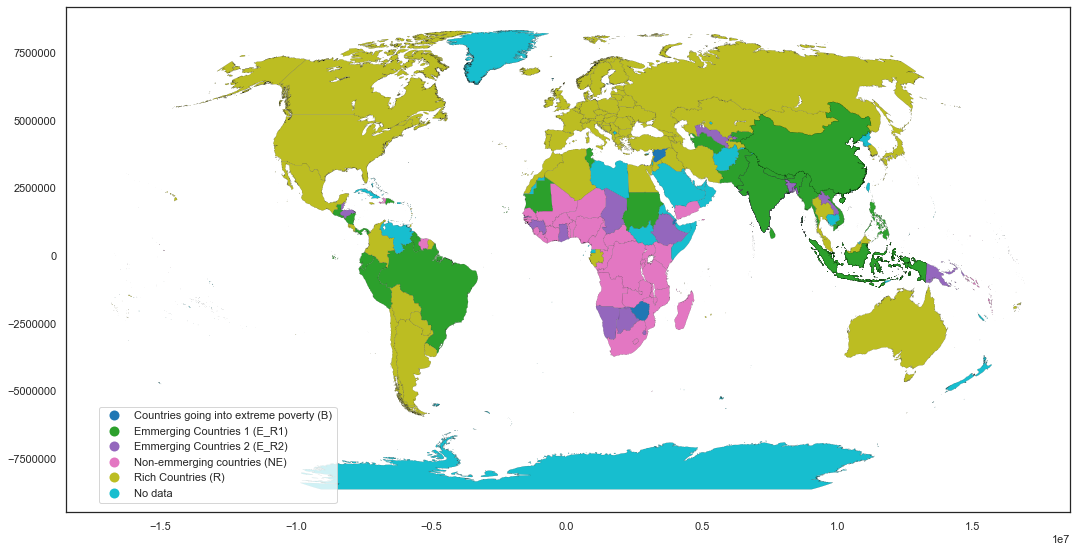

In [59]:
class_names = ["Countries going into extreme poverty (B)", "Emmerging Countries 1 (E_R1)",  
               "Emmerging Countries 2 (E_R2)",  "Non-emmerging countries (NE)",  "Rich Countries (R)", "No data"
               ]

sns.set_style("white")
shapefile = os.path.expanduser('data/ne_10m_admin_0_countries_lakes/ne_10m_admin_0_countries_lakes.shp')
gdf = gpd.read_file(shapefile)[['ADM0_A3', 'geometry']].to_crs('+proj=robin')

merged = gdf.merge(country_class, left_on='ADM0_A3', right_on='id', how="left")
merged.Class = merged.Class.astype("str")
merged = merged[['geometry', 'Class']]
ax3 = merged[['geometry', 'Class']].plot(figsize = (18,10), column="Class" , categorical=True, legend=True, edgecolor='black', linewidth=0.1)
leg = ax3.get_legend()
for i, l in enumerate(leg.get_texts()):
    l.set_text(class_names[i])
leg.set_bbox_to_anchor((0.075, 0.02, 0.2, 0.2))
# ax.set_title(title, fontsize=16, pad=20)
#ax3.legend(class_names, fontsize=12)


merged[merged.isna().any(axis=1)].plot(ax=ax3, color='#d3d3d3', hatch='///////', linewidth=0.1, edgecolor='#bdbdbd')

We then plot the histogram to show the distribution of the different classes over the countries

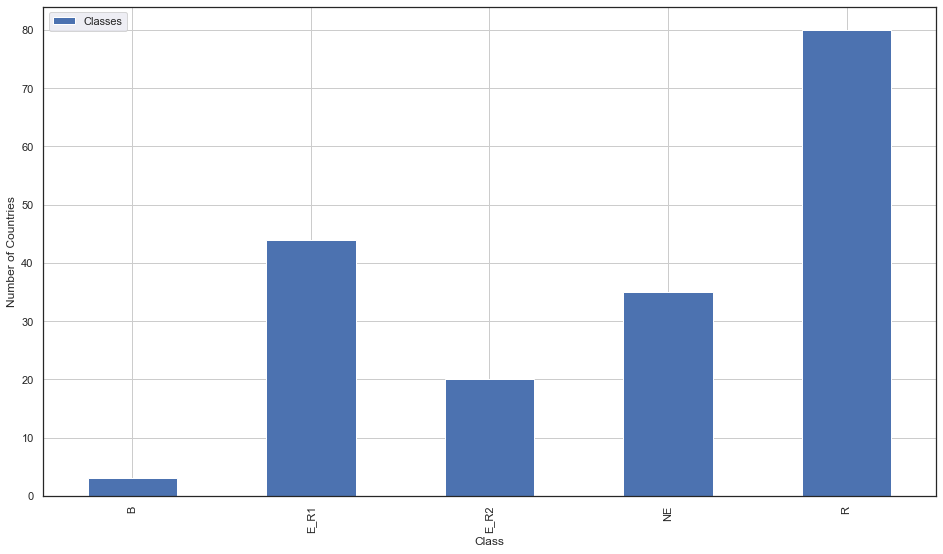

In [60]:
# Histogram that shows the distribution
group_class = country_class.groupby('Class').count()
group_class = group_class[['id']]

fig_pov = plt.figure(figsize=(16,9))
ax_pov = fig_pov.subplots()
sns.set()
group_class.plot(kind='bar', ax=ax_pov)
plt.ylabel("Number of Countries")
plt.legend(["Classes"]);
plt.savefig("graph.png", dpi=300)
plt.show()

In [61]:
def get_difference(old_year, new_year):
    """Calculate the difference between the attributes of the data from the first year
    and the second year
    
    Parameters
    ----------
    old_year : pandas Dataframe
        Data of the first year.
    new_year : pandas Dataframe
        Data of the first year.
    
    Returns
    -------
    data_diff : pandas DataFrame
        Dataframe that includes the difference between old and new year 
    """
    nonnum = old_year.select_dtypes(['object']).columns
    old_year[old_year.columns.difference(nonnum)] = old_year[old_year.columns.difference(nonnum)].mul(-1)
    data_diff = pd.concat([new_year, old_year], join='inner', ignore_index=True)
    data_diff = data_diff.loc[data_diff.CoverageType.isin(['N','A']),:]
    countries_both = old_year.id[old_year.id.isin(new_year.id)]
    data_diff = data_diff.loc[data_diff.id.isin(countries_both),:]
    data_diff = data_diff.sort_values(by=['id'])
    data_diff = data_diff.drop(['isInterpolated', 'useMicroData', 'Year'],axis=1)
    data_diff = data_diff.groupby('id').sum()
    
    return data_diff

In [62]:
data_diff = get_difference(data_ext_1990, data_ext_2015)

In [63]:
drop_columns = ['HeadCount','PovGap','PovGapSqr','Watts', 'id']

country_class = country_class[['id', 'Class']]

if 'Class' not in data_diff.columns:
    data_diff = pd.merge(data_diff, country_class, on = 'id')


y = data_diff['Class']

# Mapping maybe use maybe not
# y = y.map({'E_R1':'E', 'E_R2':'E','R':'R','NE':'O','B':'O'})
nonnum = data_diff.select_dtypes(exclude= 'float64').columns.to_list()
X = data_diff.drop(drop_columns+nonnum, axis=1)

# Remove columns with correlation
corr_cols =  correlation_handling(X,0.95)
X = X[X.columns.difference(corr_cols)]


#Create a dictionary for renaming the columns
X= X.copy()
columns = X.columns

dictnames = dict()
for k in range(len(columns)):
    dictnames[columns[k]]='col'+str(k)

X=X.rename(columns=dictnames) 
   
comebackdict = dict()
for k in range(len(X.columns)):
    comebackdict[X.columns[k]]= columns[k]

### Scale the data using standard scaler

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    shuffle=True,
                                                    random_state=1502)

### Feature selection using Random Forest

In [65]:
ros = RandomOverSampler(random_state=1)
X_train_os, y_train_os = ros.fit_sample(X_train, y_train)



model = RandomForestClassifier(n_estimators = 1000, n_jobs=-1, random_state=123)
model.fit(X_train_os,y_train_os)

y_hat = model.predict(X_test)


accuracy = sk.metrics.accuracy_score(y_test, y_hat)
balanced_accuracy = sk.metrics.balanced_accuracy_score(y_test, y_hat)
f1 = sk.metrics.f1_score(y_test,y_hat, average='weighted')

score = [accuracy, balanced_accuracy, f1]

RF_scores_df = pd.DataFrame(score, index =['Accuracy', 'Balanced Accuracy', 'F1'], 
                                              columns =['Random Forest']) 

df_conf_matrix_RF = pd.crosstab(y_test, y_hat, rownames=['True'], colnames=['Predicted'],
            margins=True)

X=X.rename(columns=comebackdict)

index = list(model.feature_importances_>0.01)
feature_importance_df_RF = pd.DataFrame({'features':X.columns[index], 'importance':  model.feature_importances_[index]})

In [66]:
feature_importance_df_RF = feature_importance_df_RF.sort_values(by='importance', ascending = False)

In [67]:
feature_importance_df_RF

,features,importance
7,Median,0.021659
6,Mean,0.019581
11,Population growth (annual %),0.017066
2,GDP per capita (constant 2010 US$),0.015864
3,"GDP per capita, PPP (constant 2011 internation...",0.015460
5,Individuals using the Internet (% of population),0.013431
8,Out-of-pocket expenditure per capita (current ...,0.011662
1,"Cause of death, by non-communicable diseases (...",0.011491
9,"Population ages 25-29, female (% of female pop...",0.010835
0,"Cause of death, by communicable diseases and m...",0.010738


In [68]:
RF_scores_df

,Random Forest
Accuracy,0.783784
Balanced Accuracy,0.570833
F1,0.754836


In [69]:
df_conf_matrix_RF

Predicted,E_R1,E_R2,NE,R,All
True,,,,,
B,0,0,1,0,1
E_R1,6,1,0,2,9
E_R2,1,1,1,1,4
NE,0,0,7,0,7
R,1,0,0,15,16
All,8,2,9,18,37


For the Random Forest Classifier we get a good prediction with an `F1 Score` of **0.75**. We run the Random Forest with a split of the data in 80% train and  20% test. As Hyper parameter for the Random Forest we try with different number of trees but with **1000** we get the best score. The best features that describe the emerging countries are seen in the data data frame above

### Feature selection using Logistic Regression

In [70]:
#Create a list of the features that we got from the Random Forest
column_list = list(feature_importance_df_RF.features.values)

In [71]:
#Getting only the new best feature columns
X_temp = data_diff.loc[:,column_list]

Xscaler = StandardScaler()
X_scaled = Xscaler.fit_transform(X_temp)

labelencoder_Y = LabelEncoder()
y_scaled = labelencoder_Y.fit_transform(y)

In [72]:
from sklearn.model_selection import cross_val_predict

embeded_lr_selector = SelectFromModel(LogisticRegression(penalty="l2"), max_features=10)


y_pred = cross_val_predict(embeded_lr_selector.estimator, X_scaled, y_scaled, cv=10)
# embeded_lr_selector.fit(X_scaled, y_scaled)
embeded_lr_selector.fit(X_scaled, y_scaled)

f1 = sk.metrics.f1_score(y_scaled, y_pred ,average='weighted')
accuracy = sk.metrics.accuracy_score(y_scaled,y_pred)
balanced_accuracy = sk.metrics.balanced_accuracy_score(y_scaled, y_pred)

score = [accuracy, balanced_accuracy, f1]

LR_scores_df = pd.DataFrame(score, index =['Accuracy', 'Balanced Accuracy', 'F1'], 
                                              columns =['Logistic Regression']) 

df_conf_matrix_LR = pd.crosstab(labelencoder_Y.inverse_transform(y_scaled), 
                                labelencoder_Y.inverse_transform(y_pred), rownames=['True'], colnames=['Predicted'],
            margins=True)


embeded_lr_support = embeded_lr_selector.get_support()
embeded_lr_feature = X_temp.loc[:,embeded_lr_support].columns.tolist()
feature_importance_df_LR = pd.DataFrame({'features':embeded_lr_feature})

In [73]:
LR_scores_df

,Logistic Regression
Accuracy,0.784530
Balanced Accuracy,0.678948
F1,0.780177


In [74]:
feature_importance_df_LR

,features
0,Median
1,Population growth (annual %)
2,"GDP per capita, PPP (constant 2011 internation..."
3,Individuals using the Internet (% of population)
4,Out-of-pocket expenditure per capita (current ...
5,"Cause of death, by communicable diseases and m..."


In [75]:
df_conf_matrix_LR

Predicted,B,E_R1,E_R2,NE,R,All
True,,,,,,
B,1,0,1,1,0,3
E_R1,0,28,6,2,8,44
E_R2,0,2,13,3,2,20
NE,0,1,0,32,2,35
R,0,7,0,4,68,79
All,1,38,20,42,80,181


As a second classifier we use `Logistic Regression` with a norm penalty `L2`. We use the same features that we get from the Random Forest. We get a sore of F1 to **0.78**.

### Feature selection using LightGBM classifier

In [77]:
feature_importance_df_LGBMC

,features
0,Median
1,Population growth (annual %)
2,Individuals using the Internet (% of population)
3,Out-of-pocket expenditure per capita (current ...
4,"Population ages 25-29, female (% of female pop..."


In [78]:
LGBMC_scores_df

,Logistic Regression
Accuracy,0.767956
Balanced Accuracy,0.656675
F1,0.763399


In [79]:
df_conf_matrix_LGB

Predicted,B,E_R1,E_R2,NE,R,All
True,,,,,,
B,1,0,0,2,0,3
E_R1,0,26,7,2,9,44
E_R2,0,4,12,2,2,20
NE,1,0,0,31,3,35
R,1,7,0,2,69,79
All,3,37,19,39,83,181


As a Third classifier we use `Light Gradient Boosting`. We use the same features that we get from the Random Forest. We get a sore of F1 to **0.76**.

In [80]:
from IPython.core.debugger import set_trace
best_feature = []
for feature  in feature_importance_df_RF.features:
    if feature in feature_importance_df_LGBMC['features']:
        best_feature.append(feature)

In [81]:
best_feature

[]

### Feature selection using Chi Square

In [82]:
X_norm = MinMaxScaler().fit_transform(X)
chi_selector = SelectKBest(chi2, k=20)
chi_selector.fit(X_norm, y_scaled)
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()
chi_values = chi_selector.pvalues_[chi_support]
feature_importance_df_chi2 = pd.DataFrame({'features':chi_feature, 'importance':  chi_values})

In [83]:
feature_importance_df_chi2.sort_values(by='importance', ascending = False)

,features,importance
12,"Population ages 70-74, male (% of male populat...",6.996537e-02
3,Domestic general government health expenditure...,6.500912e-02
11,"Population ages 45-49, female (% of female pop...",6.493617e-02
17,"Secondary education, vocational pupils",5.290099e-02
13,"Population ages 80 and above, male (% of male ...",4.654715e-02
14,Population in largest city,3.752743e-02
0,Access to clean fuels and technologies for coo...,3.104853e-02
19,"Teachers in tertiary education programmes, bot...",2.580997e-02
15,"Prevalence of obesity, male (% of male populat...",2.147364e-02
2,"Agriculture, forestry, and fishing, value adde...",2.043955e-02


In [76]:
from sklearn.model_selection import cross_val_predict
lgbc=LGBMClassifier()

embeded_lgb_selector = SelectFromModel(lgbc, max_features=10)
embeded_lgb_selector.fit(X_scaled, y_scaled)

y_pred = cross_val_predict(embeded_lgb_selector.estimator, X_scaled, y_scaled, cv=10)
# embeded_lr_selector.fit(X_scaled, y_scaled)
embeded_lr_selector.fit(X_scaled, y_scaled)

f1 = sk.metrics.f1_score(y_scaled, y_pred ,average='weighted')
accuracy = sk.metrics.accuracy_score(y_scaled,y_pred)
balanced_accuracy = sk.metrics.balanced_accuracy_score(y_scaled, y_pred)

score = [accuracy, balanced_accuracy, f1]

LGBMC_scores_df = pd.DataFrame(score, index =['Accuracy', 'Balanced Accuracy', 'F1'],
                                              columns =['Logistic Regression'])

df_conf_matrix_LGB = pd.crosstab(labelencoder_Y.inverse_transform(y_scaled),
                                labelencoder_Y.inverse_transform(y_pred), rownames=['True'], colnames=['Predicted'],
            margins=True)



embeded_lgb_support = embeded_lgb_selector.get_support()
embeded_lgb_feature = X_temp.loc[:,embeded_lgb_support].columns.tolist()
feature_importance_df_LGBMC = pd.DataFrame({'features':embeded_lgb_feature})